In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [2]:
tf.__version__

'1.8.0'

In [3]:
# 导入cifar help py script
import cifar10

In [4]:
# 下载数据集
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [5]:
# 加载数据的分类
class_names = cifar10.load_class_names()

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


In [6]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# 加载训练数据集
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [8]:
# 加载测试数据集
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [9]:
print("训练集大小:", images_train.shape, cls_train.shape, labels_train.shape)
print("测试集大小:", images_test.shape, cls_test.shape, labels_test.shape)

训练集大小: (50000, 32, 32, 3) (50000,) (50000, 10)
测试集大小: (10000, 32, 32, 3) (10000,) (10000, 10)


In [10]:
# 保存数据维度
from cifar10 import img_size, num_channels, num_classes
img_size_cropped = 24

In [11]:
# 绘制显示数据集的帮助函数
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    # 调整图片的间距
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    # 绘制子图
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        # 显示每一张图片
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        # 打印label信息
        cls_true_name = class_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "True:{0}".format(cls_true_name)
        else:
            xlabel = "True:{0} Pred:{1}".format(cls_true_name, class_names[cls_pred[i]])
        # 设置x y 轴的 ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
    plt.show()

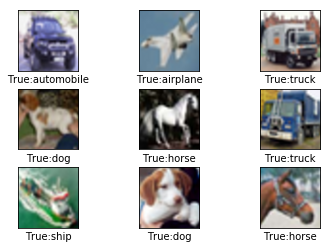

In [12]:
plot_images(images_test[9:18], cls_test[9:18])

In [13]:
# 定义基本变量的占位符
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size, img_size, num_channels], name="x")
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name="y_true")
# 变换y的类别
y_true_cls = tf.argmax(y_true, axis=1)

In [14]:
# 定义图像预处理的基本函数
def pre_process_images(image, training):
    if training:
        # 对训练集做数据增强
        # 将图像剪切为 img_size_cropped的大小
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        # 垂直翻转
        image = tf.image.random_flip_left_right(image)
        # 调整图片的色彩
        image = tf.image.random_hue(image, max_delta=0.05)
        # 调整图像的对比度
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        # 调整图像亮度
        image = tf.image.random_brightness(image, max_delta=0.2)
        # 调整饱和度
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        #将图像大小限制到0-1之间
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # 对于测试集和验证集只需要进行crop 或者pad即可
        image = tf.image.resize_image_with_crop_or_pad(image, target_height=img_size_cropped, target_width=img_size_cropped)
    return image

In [15]:
# 对每一张图片应用预处理
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_images(image, training), images)
    return images

In [16]:
# 处理图像建立计算图
distorted_images = pre_process(x, True)

In [17]:
# 对初始化 权重 和bias 需要进一步研究
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), dtype=tf.float32)

def get_bias(shape):
    return tf.Variable(tf.constant(0.05, shape=[shape]), dtype=tf.float32)

In [40]:
# 卷积层的定义
def new_conv_layer(input, filter_size, num_input_channels, num_output_channels, use_pooling=True, training=True):
    weights = get_weights([filter_size, filter_size, num_input_channels, num_output_channels])
    bias = get_bias(shape=num_output_channels)
    layer = tf.nn.conv2d(
        input=input,
        filter=weights,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )
    layer += bias
    if training is True:
        layer = tf.layers.batch_normalization(layer, training=training) 
    if use_pooling is True:
        layer = tf.nn.max_pool(
            value=layer,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='SAME'
        )
    layer = tf.nn.relu(layer)
    return layer, weights   

In [41]:
# 全连接层的定义
def new_fc_layer(input, num_input, num_output, training=True):
    # 是否后接batch_normlization层
    # 训练集的时候不需要跟bn
    if training is True:
        input = tf.layers.batch_normalization(input, training=training) 
    weights = get_weights(shape=[num_input, num_output])
    bias = get_bias(shape=num_output)
    layer = tf.nn.relu(tf.matmul(input, weights) + bias)
    return layer

In [20]:
def main_network(images, training):
    # 创建神经网络
    # 基本网络结构conv2d=》max_pool=》conv2d=》max_pool=》flatten=》fully_connect1=》fully_connnect2=》softmax
    # 输入为 24 * 24 padding为SAME 输出为 24*24  [batch_size, 24, 24, 64]
    layer1, weights1 = new_conv_layer(images, 5, 3, 64)
    print("conv layer 1:", layer1.get_shape())
    # 输入为24 * 24， 输出为 （24-2）/2 + 1 = 12*12 [batch_size, 12, 12, 64]
    # 输入为12 * 12， 输出为 12*12  [batch_size, 12, 12, 64]
    # 输入为12 * 12， 输出为 （12-2）/2 + 1 = 6*6 [batch_size, 6, 6, 64]
    layer2, weights2 = new_conv_layer(layer1, 5, 64, 64)
    print("conv layer 2:", layer2.get_shape())
    # 获取最终卷积输出的大小
    # 计算特征数 然后reshape
    layer_shape = layer2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer2, shape=[-1, num_features])
    # 搭建第一个全连接层
    print("fc layer 1:", layer_shape)
    fc1 = new_fc_layer(layer_flat, num_features, 256)
    # 创建第二个全连接层
    fc2 = new_fc_layer(fc1, 256, 128)
    # 分类层
    logits = new_fc_layer(fc2, 128, num_classes)
    print("fc layer 3:", logits.get_shape())
    pred = tf.nn.softmax(logits)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
    return loss, pred

In [21]:
# 创建网络的帮助函数
def create_main_network(training):
    images = x
    images = pre_process(images, training)
    loss, pred = main_network(images=images, training=training)
    return loss, pred

In [22]:
# 创建训练网络对训练集进行训练
loss, y_pred = create_main_network(True)

conv layer 1: (?, 12, 12, 64)
conv layer 2: (?, 6, 6, 64)
fc layer 1: (?, 6, 6, 64)
fc layer 3: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [23]:
tf.nn.conv2d??

In [24]:
# 定义一个global_step传给优化器，在进行迭代的时候每次global_step - 1
global_step = tf.Variable(initial_value=0, name="global_step", trainable=False)

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

In [26]:
# 创建测试集的验证网路 创建评估指标accuracy
y_pred_cls = tf.argmax(y_pred, axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
accuracy.shape

TensorShape([])

In [28]:
# 创建保存训练步骤的 saver
saver = tf.train.Saver()
save_dir = "checkpoints/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = os.path.join(save_dir, "cifar10_cnn")

In [29]:
# 创建tensorflow 训练图
session = tf.Session()

In [30]:
# 检查训练的恢复点，如果发现有恢复训练的模型则调用训练好的模型
try:
    print("尝试从上一个检查点恢复...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_path)
    saver.restore(session, save_path=last_chk_path)
    print("模型恢复成功")
except:
    print("恢复模型失败，尝试初始化所有变量....")
    session.run(tf.global_variables_initializer())

尝试从上一个检查点恢复...
恢复模型失败，尝试初始化所有变量....


In [31]:
# 创建随机挑选批量训练集的函数
train_batch_size = 64
def random_batch():
    num_images = len(images_train)
    idx = np.random.choice(num_images, size=train_batch_size, replace=False)
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    return x_batch, y_batch

In [32]:
# 创建训练优化的帮助函数
def optimize(num_iterations):
    start_time = time.time()
    for i in range(num_iterations):
        # 提取批量训练的数据
        x_batch, y_batch = random_batch()
        feed_dict_train = {
            x: x_batch,
            y_true: y_batch
        }
        i_global, _  = session.run([global_step, optimizer], feed_dict=feed_dict_train)
        # 每隔 100次迭代打印 迭代次数和准确率
        if(i_global % 100 == 0) or (i == num_iterations - 1):
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("迭代次数:", i_global, "准确率为：", acc)
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # 判断 每1000次迭代；或者最后一次迭代 就保存模型
            saver.save(session, save_path=save_path, global_step=global_step)
    end_time = time.time()
    time_diff = end_time - start_time
    print("耗时: " + str(timedelta(seconds=int(round(time_diff)))))

In [33]:
optimize(num_iterations=150000)

迭代次数: 100 准确率为： 0.1875
迭代次数: 200 准确率为： 0.375
迭代次数: 300 准确率为： 0.296875
迭代次数: 400 准确率为： 0.3125
迭代次数: 500 准确率为： 0.34375
迭代次数: 600 准确率为： 0.40625
迭代次数: 700 准确率为： 0.390625
迭代次数: 800 准确率为： 0.375
迭代次数: 900 准确率为： 0.375
迭代次数: 1000 准确率为： 0.46875
迭代次数: 1100 准确率为： 0.484375
迭代次数: 1200 准确率为： 0.359375
迭代次数: 1300 准确率为： 0.390625
迭代次数: 1400 准确率为： 0.53125
迭代次数: 1500 准确率为： 0.390625
迭代次数: 1600 准确率为： 0.5
迭代次数: 1700 准确率为： 0.421875
迭代次数: 1800 准确率为： 0.46875
迭代次数: 1900 准确率为： 0.46875
迭代次数: 2000 准确率为： 0.484375
迭代次数: 2100 准确率为： 0.46875
迭代次数: 2200 准确率为： 0.4375
迭代次数: 2300 准确率为： 0.40625
迭代次数: 2400 准确率为： 0.5
迭代次数: 2500 准确率为： 0.5625
迭代次数: 2600 准确率为： 0.484375
迭代次数: 2700 准确率为： 0.515625
迭代次数: 2800 准确率为： 0.5
迭代次数: 2900 准确率为： 0.53125
迭代次数: 3000 准确率为： 0.53125
迭代次数: 3100 准确率为： 0.578125
迭代次数: 3200 准确率为： 0.5625
迭代次数: 3300 准确率为： 0.5625
迭代次数: 3400 准确率为： 0.546875
迭代次数: 3500 准确率为： 0.453125
迭代次数: 3600 准确率为： 0.5625
迭代次数: 3700 准确率为： 0.546875
迭代次数: 3800 准确率为： 0.5625
迭代次数: 3900 准确率为： 0.59375
迭代次数: 4000 准确率为： 0.453125
迭代次数: 4100 准确率为： 0.5

迭代次数: 32100 准确率为： 0.734375
迭代次数: 32200 准确率为： 0.78125
迭代次数: 32300 准确率为： 0.6875
迭代次数: 32400 准确率为： 0.671875
迭代次数: 32500 准确率为： 0.703125
迭代次数: 32600 准确率为： 0.734375
迭代次数: 32700 准确率为： 0.65625
迭代次数: 32800 准确率为： 0.734375
迭代次数: 32900 准确率为： 0.609375
迭代次数: 33000 准确率为： 0.6875
迭代次数: 33100 准确率为： 0.71875
迭代次数: 33200 准确率为： 0.71875
迭代次数: 33300 准确率为： 0.765625
迭代次数: 33400 准确率为： 0.734375
迭代次数: 33500 准确率为： 0.765625
迭代次数: 33600 准确率为： 0.734375
迭代次数: 33700 准确率为： 0.671875
迭代次数: 33800 准确率为： 0.78125
迭代次数: 33900 准确率为： 0.6875
迭代次数: 34000 准确率为： 0.625
迭代次数: 34100 准确率为： 0.578125
迭代次数: 34200 准确率为： 0.71875
迭代次数: 34300 准确率为： 0.671875
迭代次数: 34400 准确率为： 0.625
迭代次数: 34500 准确率为： 0.71875
迭代次数: 34600 准确率为： 0.578125
迭代次数: 34700 准确率为： 0.65625
迭代次数: 34800 准确率为： 0.703125
迭代次数: 34900 准确率为： 0.671875
迭代次数: 35000 准确率为： 0.734375
迭代次数: 35100 准确率为： 0.609375
迭代次数: 35200 准确率为： 0.703125
迭代次数: 35300 准确率为： 0.71875
迭代次数: 35400 准确率为： 0.703125
迭代次数: 35500 准确率为： 0.71875
迭代次数: 35600 准确率为： 0.5625
迭代次数: 35700 准确率为： 0.71875
迭代次数: 35800 准确率为： 0.75
迭代次

迭代次数: 63500 准确率为： 0.671875
迭代次数: 63600 准确率为： 0.78125
迭代次数: 63700 准确率为： 0.65625
迭代次数: 63800 准确率为： 0.78125
迭代次数: 63900 准确率为： 0.71875
迭代次数: 64000 准确率为： 0.765625
迭代次数: 64100 准确率为： 0.640625
迭代次数: 64200 准确率为： 0.859375
迭代次数: 64300 准确率为： 0.671875
迭代次数: 64400 准确率为： 0.796875
迭代次数: 64500 准确率为： 0.75
迭代次数: 64600 准确率为： 0.75
迭代次数: 64700 准确率为： 0.6875
迭代次数: 64800 准确率为： 0.671875
迭代次数: 64900 准确率为： 0.734375
迭代次数: 65000 准确率为： 0.765625
迭代次数: 65100 准确率为： 0.765625
迭代次数: 65200 准确率为： 0.78125
迭代次数: 65300 准确率为： 0.734375
迭代次数: 65400 准确率为： 0.796875
迭代次数: 65500 准确率为： 0.734375
迭代次数: 65600 准确率为： 0.75
迭代次数: 65700 准确率为： 0.796875
迭代次数: 65800 准确率为： 0.6875
迭代次数: 65900 准确率为： 0.796875
迭代次数: 66000 准确率为： 0.765625
迭代次数: 66100 准确率为： 0.84375
迭代次数: 66200 准确率为： 0.65625
迭代次数: 66300 准确率为： 0.734375
迭代次数: 66400 准确率为： 0.75
迭代次数: 66500 准确率为： 0.765625
迭代次数: 66600 准确率为： 0.78125
迭代次数: 66700 准确率为： 0.859375
迭代次数: 66800 准确率为： 0.625
迭代次数: 66900 准确率为： 0.765625
迭代次数: 67000 准确率为： 0.796875
迭代次数: 67100 准确率为： 0.765625
迭代次数: 67200 准确率为： 0.75
迭代次数: 673

迭代次数: 95000 准确率为： 0.765625
迭代次数: 95100 准确率为： 0.75
迭代次数: 95200 准确率为： 0.796875
迭代次数: 95300 准确率为： 0.75
迭代次数: 95400 准确率为： 0.765625
迭代次数: 95500 准确率为： 0.765625
迭代次数: 95600 准确率为： 0.8125
迭代次数: 95700 准确率为： 0.75
迭代次数: 95800 准确率为： 0.765625
迭代次数: 95900 准确率为： 0.8125
迭代次数: 96000 准确率为： 0.8125
迭代次数: 96100 准确率为： 0.75
迭代次数: 96200 准确率为： 0.828125
迭代次数: 96300 准确率为： 0.859375
迭代次数: 96400 准确率为： 0.796875
迭代次数: 96500 准确率为： 0.6875
迭代次数: 96600 准确率为： 0.734375
迭代次数: 96700 准确率为： 0.8125
迭代次数: 96800 准确率为： 0.828125
迭代次数: 96900 准确率为： 0.84375
迭代次数: 97000 准确率为： 0.84375
迭代次数: 97100 准确率为： 0.796875
迭代次数: 97200 准确率为： 0.734375
迭代次数: 97300 准确率为： 0.75
迭代次数: 97400 准确率为： 0.796875
迭代次数: 97500 准确率为： 0.75
迭代次数: 97600 准确率为： 0.703125
迭代次数: 97700 准确率为： 0.734375
迭代次数: 97800 准确率为： 0.8125
迭代次数: 97900 准确率为： 0.6875
迭代次数: 98000 准确率为： 0.75
迭代次数: 98100 准确率为： 0.875
迭代次数: 98200 准确率为： 0.703125
迭代次数: 98300 准确率为： 0.734375
迭代次数: 98400 准确率为： 0.796875
迭代次数: 98500 准确率为： 0.765625
迭代次数: 98600 准确率为： 0.859375
迭代次数: 98700 准确率为： 0.796875
迭代次数: 98800 准确率为： 0.8

迭代次数: 125600 准确率为： 0.75
迭代次数: 125700 准确率为： 0.78125
迭代次数: 125800 准确率为： 0.765625
迭代次数: 125900 准确率为： 0.734375
迭代次数: 126000 准确率为： 0.828125
迭代次数: 126100 准确率为： 0.8125
迭代次数: 126200 准确率为： 0.84375
迭代次数: 126300 准确率为： 0.796875
迭代次数: 126400 准确率为： 0.8125
迭代次数: 126500 准确率为： 0.953125
迭代次数: 126600 准确率为： 0.859375
迭代次数: 126700 准确率为： 0.71875
迭代次数: 126800 准确率为： 0.75
迭代次数: 126900 准确率为： 0.671875
迭代次数: 127000 准确率为： 0.75
迭代次数: 127100 准确率为： 0.859375
迭代次数: 127200 准确率为： 0.8125
迭代次数: 127300 准确率为： 0.78125
迭代次数: 127400 准确率为： 0.890625
迭代次数: 127500 准确率为： 0.84375
迭代次数: 127600 准确率为： 0.796875
迭代次数: 127700 准确率为： 0.828125
迭代次数: 127800 准确率为： 0.75
迭代次数: 127900 准确率为： 0.890625
迭代次数: 128000 准确率为： 0.8125
迭代次数: 128100 准确率为： 0.90625
迭代次数: 128200 准确率为： 0.796875
迭代次数: 128300 准确率为： 0.75
迭代次数: 128400 准确率为： 0.890625
迭代次数: 128500 准确率为： 0.828125
迭代次数: 128600 准确率为： 0.71875
迭代次数: 128700 准确率为： 0.796875
迭代次数: 128800 准确率为： 0.796875
迭代次数: 128900 准确率为： 0.828125
迭代次数: 129000 准确率为： 0.765625
迭代次数: 129100 准确率为： 0.84375
迭代次数: 129200 准确率为： 0.828125
